# Table of content

## [I. Intro](#intro)
## [II. Dataset](#dataset)
## [III. Data augmentation](#data-augmentation)
## [IV. Base model selection](#base-model-selection)
## [V. Hyper parameters tuning](#hpo)
## [VI. K-fold cross validation](#k-fold_cross_validation)

# I. Intro <a class="anchor" id="intro"></a>

To keep this notebook from being too long, a second file named `utility.py` store all the basic functions and class (dataset + training). Feel free to check it for a better understanding of the notebook. This work is shared for beginners who wants a solution for the competition `petals to the metals` from the Kaggle platform. 

WARNING : I am a student and I am still learning ! It took me a couple of month to develop this solution that I am satisfied with. I am not a professionnal by any mean and this work may content some basic error, bad optimization... Contact me and I'll be happy to correct them :)

Hardware :
- CPU : TR1920x 12C/24T @ 3.9Ghz
- RAM : 128Gb DDR4 @ 3200Mhz
- GPU : RTX 3090 EVGA FTW3

## Import library

In [1]:
import sys
import logging
import gc
import time
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from tqdm.notebook import tqdm

import torch
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader, ConcatDataset, SubsetRandomSampler
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import Adam

from torchvision.models import densenet161, efficientnet_v2_l, vgg19_bn

from sklearn.model_selection import KFold

# side file containing all the utility function and class
from utility import FlowerDataset, model_trainer

In [2]:
print(torch.__version__)

2.5.0.dev20240617+cu121


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f'Device : {DEVICE}')

Device : cuda


# II. Dataset <a class="anchor" id="dataset"></a>

The dataset class is define in the `utility.py` file, with functions inspired by [this notebook]('https://www.kaggle.com/code/adikaboost/transfer-learning-efficientnet-pytorch') (credit to BOOTLEG).

In [4]:
DATASET_PATH = "./tfrecords-jpeg-512x512"
# batch size is limited by the amount of available GPU memory (24Gb) 
BATCH_SIZE = 8
NUM_CLASSES = 104
IMG_RESOLUTION = (512, 512)

In [5]:
train_data = FlowerDataset(DATASET_PATH, 'train', num_classes=NUM_CLASSES)
val_data = FlowerDataset(DATASET_PATH, 'val', num_classes=NUM_CLASSES)

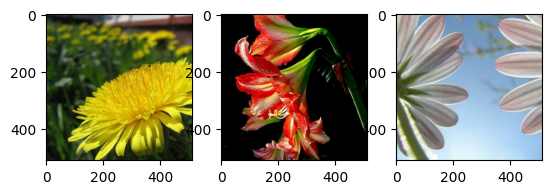

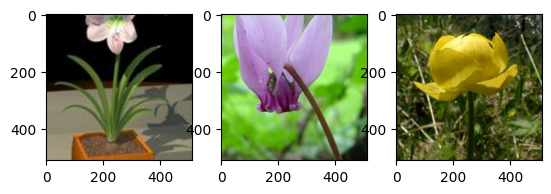

In [6]:
n_rows = 2
n_cols = 3

for _ in range(0, n_rows):
    fig, ax = plt.subplots(1, n_cols)
    for n in range(0, n_cols):    
        idx = random.randint(1, len(train_data))
        img = train_data[idx][2]
        ax[n].imshow(img)

# III. Data augmentation <a class="anchor" id="data-augmentation"></a>

The data transformation can probably be upgraded to better suit the dataset.

## Random dropout

The code below is inspired by this [notebook](https://www.kaggle.com/code/tuckerarrants/kfold-efficientnet-augmentation-s#III.-Augmentation).

In [5]:
class RandomImgDropout(object):
    """
        Apply randomly drops out rectangular regions of an image by setting them to zero. 

        Attributes:
        - p (float): Probability of applying the dropout transformation. Default is 0.5.
        - dim (int): Dimension of the image (assuming a square image). Default is IMG_RESOLUTION[0].
        - n_dropout (int): Number of dropout regions to create in the image. Default is 5.
        - scaled_size (float): Size of the dropout regions as a fraction of the image dimension. Default is 0.1.

        Parameters:
            img (torch.Tensor): Input image tensor of shape (C, H, W).

        Returns:
            torch.Tensor: Output image tensor of shape (C, H, W).
    """
    
    def __init__(self, p=0.5, dim=IMG_RESOLUTION[0], n_dropout=5, scaled_size=0.1):
        self.p = p
        self.dim = dim
        self.n_dropout = n_dropout
        self.scaled_size = scaled_size
            
    def __call__(self, img):
        do_tr = torch.rand(1)[0] < self.p
        
        if not do_tr:
            return img

        for _ in range(0, self.n_dropout):
            x = torch.randint(0, self.dim, ()).type(torch.int32)
            y = torch.randint(0, self.dim, ()).type(torch.int32)
            width = torch.tensor(self.scaled_size * self.dim, dtype=torch.int32)

            ya = torch.maximum(y-width//2, torch.tensor(0, dtype=torch.int32))
            yb = torch.minimum(y+width//2, torch.tensor(self.dim, dtype=torch.int32))
            xa = torch.maximum(x-width//2, torch.tensor(0, dtype=torch.int32))
            xb = torch.minimum(x+width//2, torch.tensor(self.dim, dtype=torch.int32))

            img[:, ya:yb, xa:xb] = 0
            
        return img

In [6]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [7]:
visual_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=IMG_RESOLUTION, scale=(0.8, 1)),
    transforms.RandomEqualize(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ElasticTransform(alpha=80.0)]),
    transforms.RandomPerspective(distortion_scale=(0.3), p=0.4),
    transforms.PILToTensor(),
    RandomImgDropout(scaled_size=0.12, n_dropout=10),
    transforms.ToPILImage()
])

# Same as visual transform but convert image to a normalize tensor at the end
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=IMG_RESOLUTION, scale=(0.8, 1)),
    transforms.RandomEqualize(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ElasticTransform(alpha=80.0)]),
    transforms.RandomPerspective(distortion_scale=(0.3), p=0.4),
    transforms.PILToTensor(),
    RandomImgDropout(scaled_size=0.12, n_dropout=10),
    transforms.ToDtype(torch.float32),
    transforms.Normalize(*stats,inplace=True)
])

val_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32),
    transforms.Normalize(*stats,inplace=True)
])

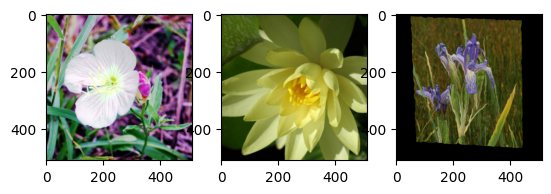

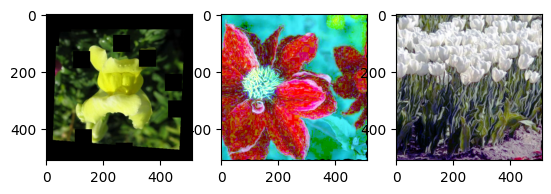

In [10]:
train_data.transform = visual_transform

n_rows = 2
n_cols = 3

for _ in range(0, n_rows):
    fig, ax = plt.subplots(1, n_cols)
    for n in range(0, n_cols):    
        idx = random.randint(1, len(train_data))
        img = train_data[idx][2]
        ax[n].imshow(img)

In [11]:
train_data.transform = train_transform
val_data.transform = val_transform

## (Optionnal) Benchmark of the CPU with the dataloader

The goal of this benchmark is to use an optimal number of thread to process the dataset and avoid a potential bottleneck of the CPU 'feeding' the GPU to slowly.

The cell below have been converted to raw format to avoid accidentaly running the benchmark at each restart of the notebook. 

As shown in the plot below, the optimal number of workers for this hardware is 16 (fast enough without to much power consumption from using all the threads).

![CPU Benchmark](./cpu_benchmark.png "AVG time to process the dataset per number of workers")

In [8]:
N_WORKERS = 16

In [13]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=N_WORKERS, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=N_WORKERS, shuffle=True, drop_last=True)

# IV. Base model selection <a class="anchor" id="base-model-selection"></a>

Now, the selection of the best base model can be done. For that, some preselected CNN will be benchmarked and the one with the best accuracy after a 10 epoch of training will be used as the base model.

Here are all the models that will be tested:
- DenseNet161
- EfficientNetV2-L
- VGG-19_BN

In [14]:
# replace the final layer of each model to a new one with the right amount of classes
densenet_model = densenet161(weights='DEFAULT')
densenet_model.classifier = nn.LazyLinear(out_features=NUM_CLASSES)

efficient_model = efficientnet_v2_l(weights='DEFAULT')
efficient_model.classifier[-1] = nn.LazyLinear(out_features=NUM_CLASSES)

vgg_model = vgg19_bn(weights='DEFAULT')
vgg_model.classifier[-1] = nn.LazyLinear(out_features=NUM_CLASSES)

models = {
    'densenet161': densenet_model,
    'efficientnet_v2_l': efficient_model,
    'vgg19_bn': vgg_model
}

The cell below has been converted to raw format to avoid accidentally running the benchmark at each restart of the notebook.

In [15]:
models_benchmark_df = pd.read_csv('./models_benchmark.csv')

In [16]:
models_benchmark_df.head()

,densenet161_train_loss,densenet161_train_accuracy,densenet161_val_loss,densenet161_val_accuracy,efficientnet_v2_l_train_loss,efficientnet_v2_l_train_accuracy,efficientnet_v2_l_val_loss,efficientnet_v2_l_val_accuracy,vgg19_bn_train_loss,vgg19_bn_train_accuracy,vgg19_bn_val_loss,vgg19_bn_val_accuracy
0,3.848307,0.107347,4.387936,0.162177,3.544046,0.167098,4.326174,0.111261,4.257710,0.062181,4.289004,0.101024
1,3.301587,0.184114,3.122739,0.222252,2.572201,0.334431,2.168596,0.412446,3.963529,0.093468,3.867229,0.102371
2,2.982319,0.242610,2.767950,0.307381,2.077239,0.440132,1.687266,0.550108,3.873457,0.104211,3.746097,0.127155
3,2.746424,0.288403,2.909217,0.293373,1.701240,0.543402,1.388722,0.630927,3.849100,0.107426,3.672092,0.129580
4,2.502348,0.348859,2.350137,0.381735,1.431664,0.611150,1.197738,0.679957,3.932663,0.104916,3.745596,0.112069


#### densenet161 stats ####


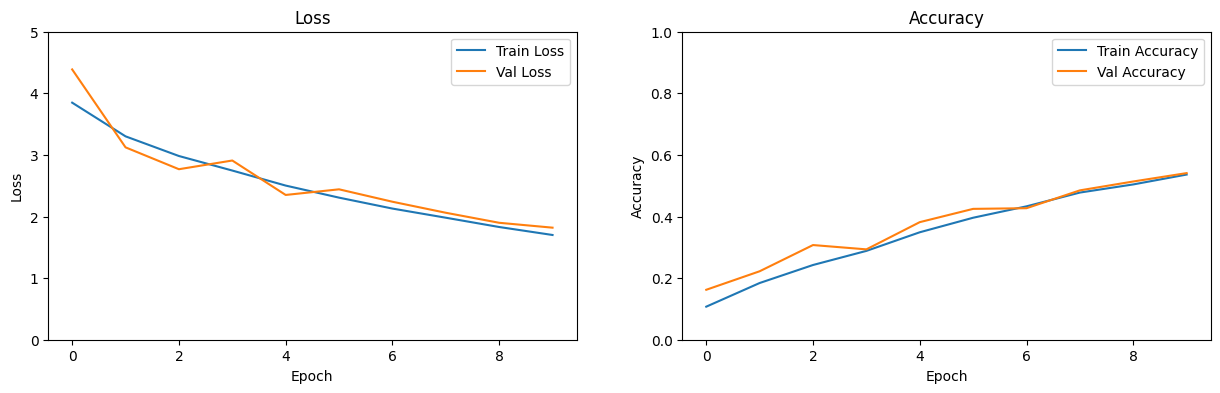

#### efficientnet_v2_l stats ####


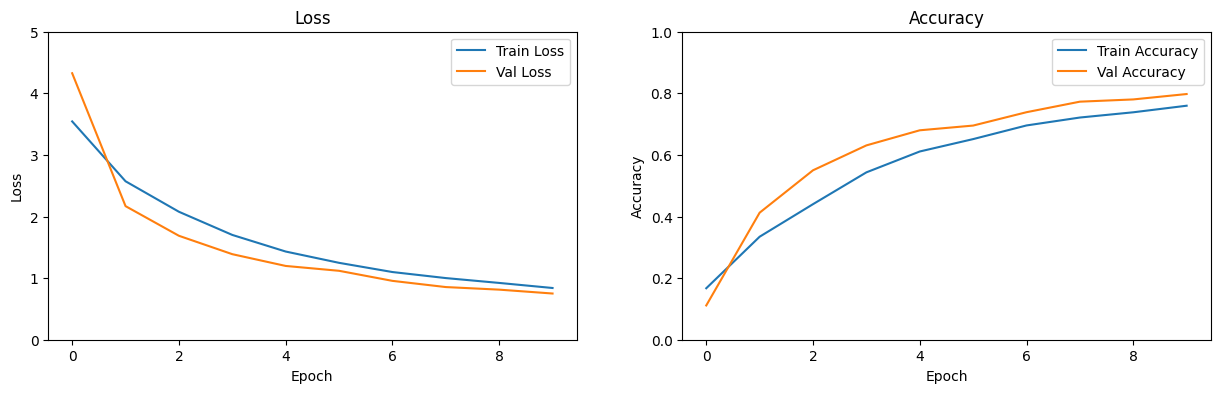

#### vgg19_bn stats ####


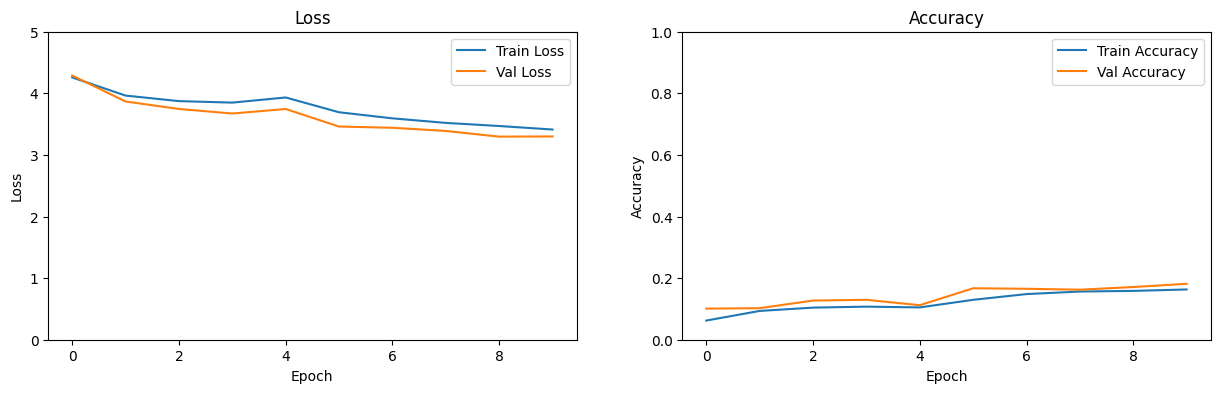

In [17]:
for model_name in models.keys():
    print(f"#### {model_name} stats ####")
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 4)

    # Plotting loss
    ax[0].set_ylim([0, 5])
    ax[0].plot(models_benchmark_df[model_name + '_train_loss'], label='Train Loss')
    ax[0].plot(models_benchmark_df[model_name + '_val_loss'], label='Val Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_title('Loss')
    ax[0].legend()

    # Plotting accuracy
    ax[1].set_ylim([0, 1])
    ax[1].plot(models_benchmark_df[model_name + '_train_accuracy'], label='Train Accuracy')
    ax[1].plot(models_benchmark_df[model_name + '_val_accuracy'], label='Val Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.show()

The efficient V2 large model is the one which perform the best with a better accuracy than the others one after 10 epochs of training. It converge faster then the densenet 161 while still having a validation loss smaller than the training loss which mean that there is still room for even better performance.

All the model do not overfit at all, which can suggest that the data augmentation is ok.

# V. Hyper parameters tuning <a class="anchor" id="hpo"></a>

Now that the base model has been selected (efficient V2 large), I am going to proceed to a hyper parameters search to improve the base model. The goal of this search will be to find a good classifier architecture with the right amount of hidden and the right amount of dropout and perceptrons per hidden layer.

The library used for this HPO is optuna, which is simple to work with.
We only need to create an objective function that will ask for hyperparameters variables and return a score. The framework will try to optimize the score of the objective function by giving better combinations of variables values.

## 1. Custom classifier function

This function will take in input some hyper parameters variables and return a Sequential container with the applied inputs.

In [20]:
def get_custom_classifier(linear_layers: list, dropout_layers: list, bn_layers: list):
    layers = []
    for out_features, dropout_rate, is_bn in zip(linear_layers, dropout_layers, bn_layers):
        layers.append(nn.Dropout(p=dropout_rate))
        layers.append(nn.LazyLinear(out_features))
        if is_bn : layers.append(nn.LazyBatchNorm1d())
        layers.append(nn.ReLU())
        
    layers.append(nn.LazyLinear(NUM_CLASSES))
    layers.append(nn.Softmax(dim=1))
    return nn.Sequential(*layers)

## 2. Objective function && data retrieval

In [19]:
def objective(trial):     
    model = efficientnet_v2_l(weights='DEFAULT')
    
    n_hidden_layers = trial.suggest_int('num_hidden_layers', 0, 3)
    linear_layers = []
    dropout_layers = []
    bn_layers = []
    
    for i in range(0, n_hidden_layers):
        linear_layers.append(trial.suggest_int(f'l{i}_out_features', 128, 1024, step=32))
        dropout_layers.append(trial.suggest_float(f'l{i}_dropout_rate', 0, 0.6))
        bn_layers.append(trial.suggest_categorical(f'l{i}_is_bn', [True, False]))

    model.classifier = get_custom_classifier(linear_layers, dropout_layers, bn_layers)

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-5)
    
    hist = model_trainer(model, criterion, optimizer, train_loader, val_loader=val_loader, epochs=15, device=DEVICE, show_progress=False, trial=trial)

    model.cpu()
    del model, criterion, optimizer
    gc.collect()
    torch.cuda.empty_cache()

    return hist['val_accuracy'][-1]

## 3. Let the calculation begin ! 

I actually wasn't able to run the hyper parameters search within the jupyterlab interface as it requires to keep the tab open to maintain the connection and the kernel would die after a certain amount of time (I don't know why).

Here is how I did :
- Convert the notebook to a .py file using this command line : `jupyter nbconvert --to script petals_to_the_metals.ipynb`
- Rename the file : `mv ./petals_to_the_metals.py ./hyper_parameter_tuning.py`
- Clear the code to just run the HPO and save the result within `HPO.csv` file and add logging info to track the process
- Start the HPO with this command line : `nohup python hyperparameter_tuning.py > hyper_parameter_tuning.log 2>&1 &` which will start a new background process that will not stop on the jupyterlab session closing

In [20]:
HPO_df = pd.read_csv('./HPO.csv').sort_values('value', ascending=False)

In [21]:
HPO_df.head()

,number,value,datetime_start,datetime_complete,duration,params_l0_dropout_rate,params_l0_is_bn,params_l0_out_features,params_l1_dropout_rate,params_l1_is_bn,params_l1_out_features,params_l2_dropout_rate,params_l2_is_bn,params_l2_out_features,params_num_hidden_layers,state
0,0,0.959052,2024-06-14 09:17:49.660301,2024-06-14 11:49:25.970254,0 days 02:31:36.309953,0.385510,True,1024.0,NaN,NaN,NaN,NaN,NaN,NaN,1,COMPLETE
51,51,0.958782,2024-06-16 06:24:31.295515,2024-06-16 08:55:49.292319,0 days 02:31:17.996804,0.008753,False,992.0,NaN,NaN,NaN,NaN,NaN,NaN,1,COMPLETE
6,6,0.958782,2024-06-14 22:16:21.551971,2024-06-15 00:47:29.809512,0 days 02:31:08.257541,0.118101,False,896.0,NaN,NaN,NaN,NaN,NaN,NaN,1,COMPLETE
61,61,0.958513,2024-06-16 15:29:39.727421,2024-06-16 18:01:05.459980,0 days 02:31:25.732559,0.005597,False,1024.0,NaN,NaN,NaN,NaN,NaN,NaN,1,COMPLETE
73,73,0.957435,2024-06-16 23:14:43.889896,2024-06-17 01:46:17.308127,0 days 02:31:33.418231,0.020938,False,992.0,NaN,NaN,NaN,NaN,NaN,NaN,1,COMPLETE


The best parameters for the classifier seems to be a single hidden layer with 1024 perceptronsand with a dropout of ~0.38. Using batch normalization does not seem to have a significant impact.

In [15]:
hidden_layers = [1024] 
dropout_layers = [0.38] 
bn_layers = [False]

# VI. K-fold cross validation <a class="anchor" id="k-fold_cross_validation"></a>

## Learning rate scheduler

### Features extractor

Since we are using a pretrained model, it is important to have a specific learning rate scheduler shich will update the pretrained weights slowly at the beginning to avoid overshooting or getting stuck in suboptimal points.

Here is the learning rate stratgey that will be use :
1. warmup stage : adjust to the new dataset without making large, potentially harmful updates
2. aggressive learning rate at the middle of the training to make the model converge faster
3. decrease the learning rate to better find a local minima

The code below is taken from [this notebook](https://www.kaggle.com/code/tuckerarrants/kfold-efficientnet-augmentation-s#IV.-Model-Training).

In [10]:
# since the model is pretrained and the batch size is small, a small lr is better
head_lr_start = 1e-5
head_lr_min = 1e-5
head_lr_max = 1e-4
head_lr_rampup_epochs = 5
head_lr_sustain_epoch = 0
head_lr_decay = .8

def custom_head_lr_scheduler(epoch):
    if epoch < head_lr_rampup_epochs:
        return (head_lr_max - head_lr_start) / head_lr_rampup_epochs * epoch + head_lr_start
        
    elif epoch < head_lr_rampup_epochs + head_lr_sustain_epoch:
        return head_lr_max
        
    else:
        return (head_lr_max - head_lr_min) * head_lr_decay**(epoch - head_lr_rampup_epochs - head_lr_sustain_epoch) + head_lr_min

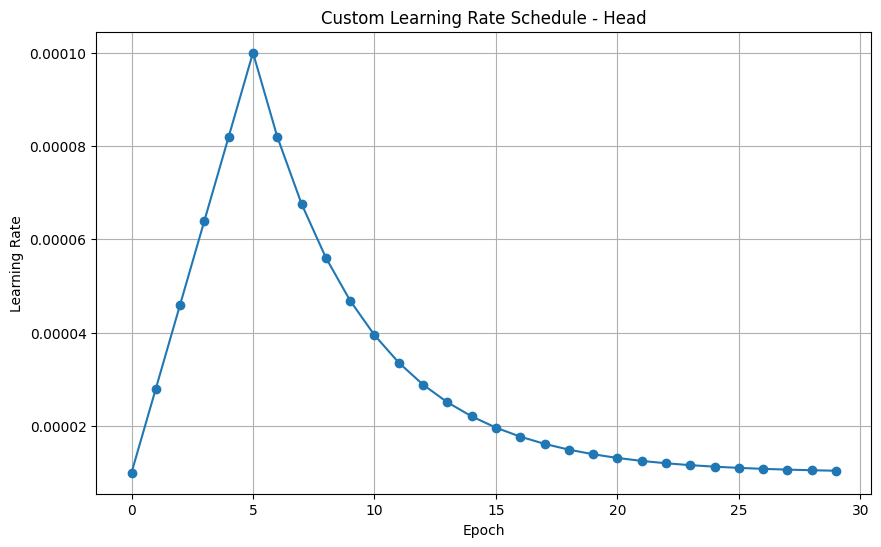

In [24]:
# Generate learning rates for each epoch
learning_rates = [custom_head_lr_scheduler(epoch) for epoch in range(0, 30)]

# Plot the learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(range(0, 30), learning_rates, marker='o')
plt.title('Custom Learning Rate Schedule - Head')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)

plt.show()

### Classifier

The classifier is made of one hidden layer and the final layer and is trained from scratch (no pretraining).
A warmup cooldown strategy is not necessary for non-pretrained weights so a decay of the learning time over epoch will be used.

In [11]:
# same for the classifier, low lr because of small batch size
clr_lr_max = 1e-4
clr_lr_min = 1e-6
clr_lr_decay = 0.8

def custom_clr_lr_scheduler(epoch):
    lr = (clr_lr_max - clr_lr_min) * clr_lr_decay**(epoch) + clr_lr_min
    return lr

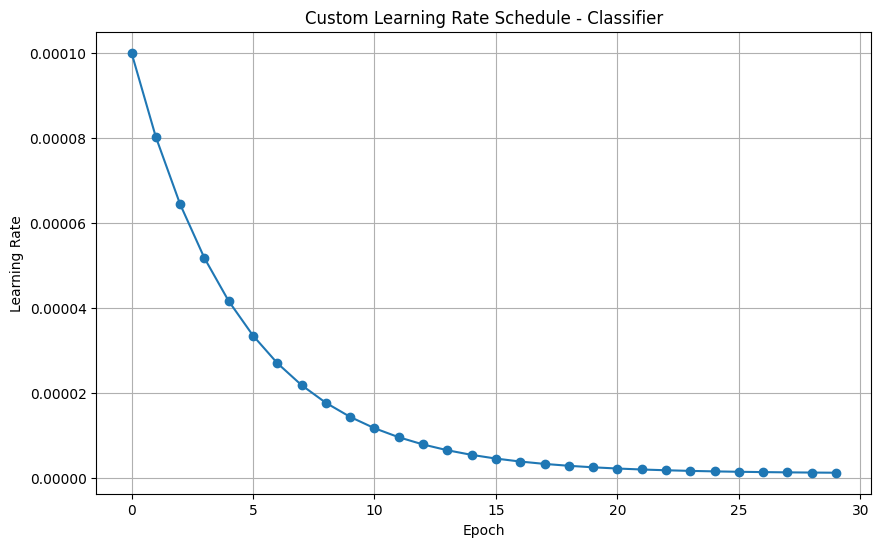

In [26]:
# Generate learning rates for each epoch
learning_rates = [custom_clr_lr_scheduler(epoch) for epoch in range(0, 30)]

# Plot the learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(range(0, 30), learning_rates, marker='o')
plt.title('Custom Learning Rate Schedule - Classifier')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)

plt.show()

## Early stopping

From this [stackoverflow topic](https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch).

In [12]:
# Early stop class based of the trend of a given loss
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.early_stop = False

    def step(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

## Training function with early stopping

Since the dataloader dynamically change from a folder to another during training, I had to pass the dataset as an argument of the training function and to dynamically change the transform attribute of the dataset. 

In [28]:
def es_training(model, optimizer, criterion, dataset, train_loader, val_loader, epochs, patience, min_delta, scheluder = None, device='cpu'):
    early_stopper = EarlyStopper(patience, min_delta)
    model.to(device)

    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(0, epochs):        
        model.train()
        # change the data augmentation to match the training stage
        dataset.transform = train_transform
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for _, labels, inputs in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            # Calculate statistics            
            _, predicted = torch.max(outputs.data, 1)
            _, y_class = torch.max(labels.data, 1)
            train_loss += loss.item()
            train_total += labels.size(0)
            train_correct += (predicted == y_class).sum().item()

        # Update lr
        if scheduler is not None:
            scheduler.step()
            
        # Calculate average training loss and accuracy for the epoch
        train_epoch_loss = train_loss / len(train_loader)
        train_epoch_accuracy = train_correct / train_total

        model.eval()
        # change the data augmentation to match the evaluating stage
        dataset.transform = val_transform
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for _, labels, inputs in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Calculate statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                _, y_class = torch.max(labels.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == y_class).sum().item()

        # Calculate average validation loss and accuracy for the epoch
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_accuracy = val_correct / val_total

        # update history
        history['train_loss'].append(train_epoch_loss)
        history['train_accuracy'].append(train_epoch_accuracy)
        history['val_loss'].append(val_epoch_loss)
        history['val_accuracy'].append(val_epoch_accuracy)

        print(
            f'Epoch {epoch} completed',
            f'training loss = {train_epoch_loss}',
            f'training accuracy = {train_epoch_accuracy}',
            f'val loss = {val_epoch_loss}',
            f'val accuracy = {val_epoch_accuracy}',
            sep=' | '
        )

        # check for early stop
        early_stopper.step(val_epoch_loss)
        if early_stopper.early_stop:
            print('-'*5 + f'Early stop trigger --> stopping training' + '-'*5)
            break

    return history

## Defining K-fold variables

In [21]:
def get_model():
    model = efficientnet_v2_l(weights='DEFAULT')
    
    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True
    
    model.classifier = get_custom_classifier(hidden_layers, dropout_layers, bn_layers)
        
    return model

In [13]:
random_state = 3210
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

In [22]:
k_models = [get_model() for _ in range(0, k_folds)]

In [32]:
# the training and validation dataset are no longer needed
del train_data, val_data
gc.collect()

18

In [16]:
# I did a copy of the content of the 'train' and the 'val' folder into a new 'train+val' folder to load the entire dataset
dataset = FlowerDataset(DATASET_PATH, 'train+val')

## K-fold training

Same problem as the hyper parameter search, when running the code below, after some times the kernel and the session is shutting down automatically which stop the training.

Here is how I managed it :

1. Convert the notebook to a .py file using this command line : `jupyter nbconvert --to script petals_to_the_metals.ipynb`
2. Rename the file : `mv ./petals_to_the_metals.py ./k-fold_training.py`
3. Clear the code to just run the training and save the result within the `k-fold_training_histories.csv` file and add logging info to track the process
4. Start the training with this command line : `nohup python k-fold_training.py > k-fold_training.log 2>&1 &` which will start a new background process that will not stop on the jupyterlab session closing

In [34]:
# Early stop variables
es_patience = 5
es_min_delta = 0.02

In [35]:
criterion = nn.CrossEntropyLoss()
epochs = 50
histories = {}

The cell below has been converted to raw format to avoid accidentally running the training at each restart of the notebook.

In [36]:
histories = pd.read_csv('./k-fold_training_histories.csv')

## Models metrics

####### MODEL FOLD 0 #######


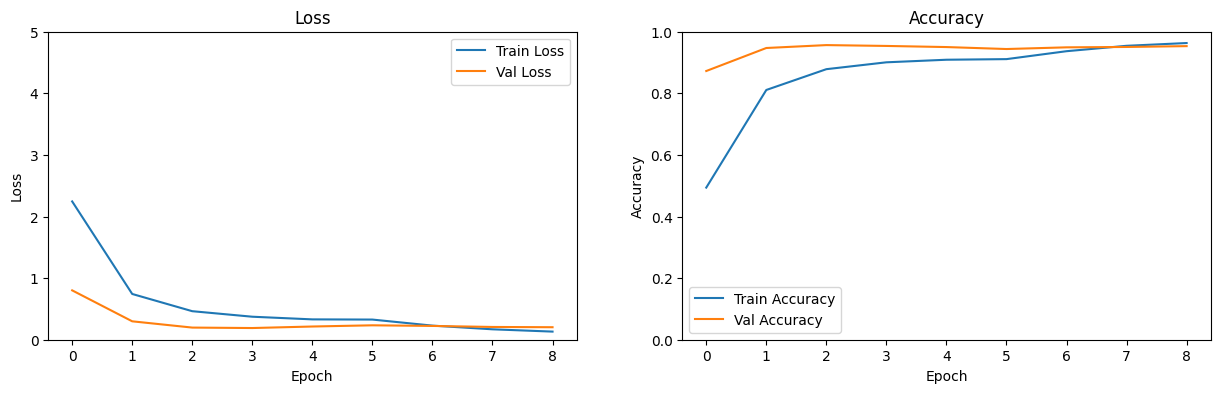

####### MODEL FOLD 1 #######


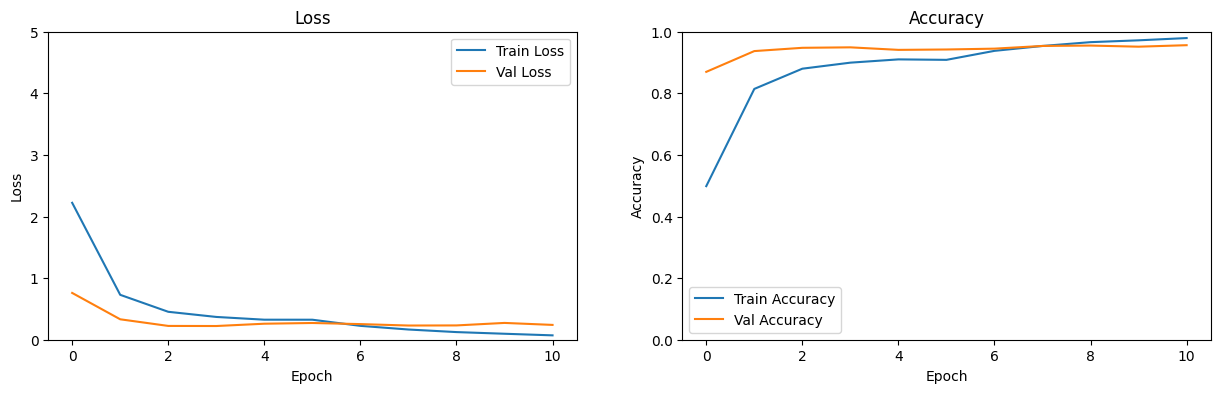

####### MODEL FOLD 2 #######


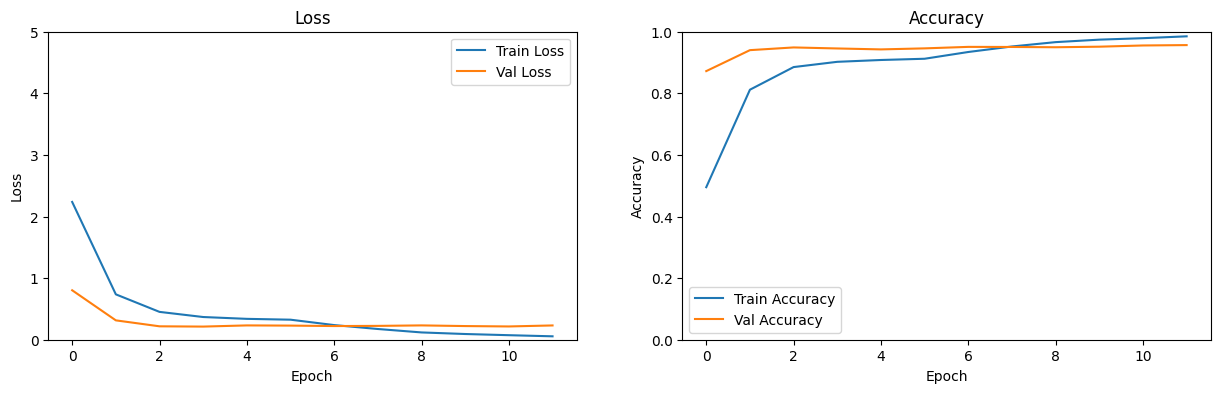

####### MODEL FOLD 3 #######


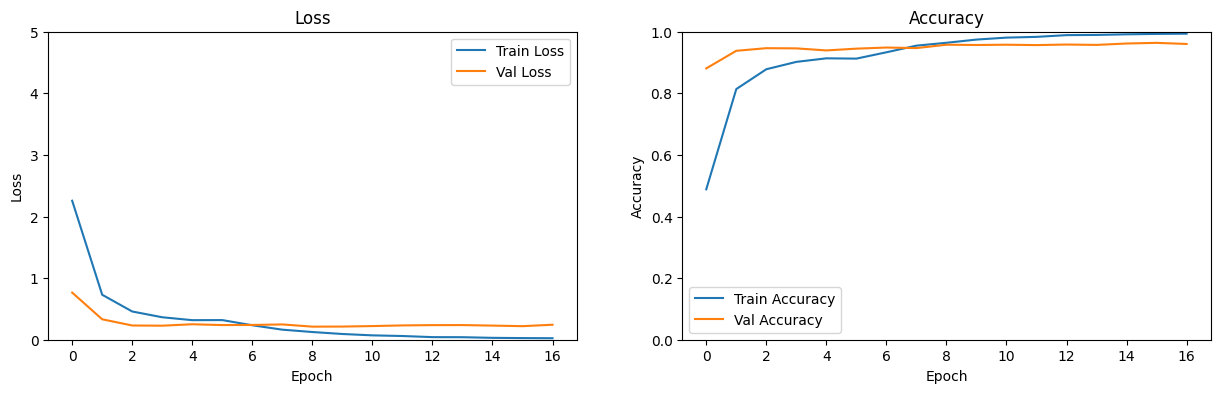

####### MODEL FOLD 4 #######


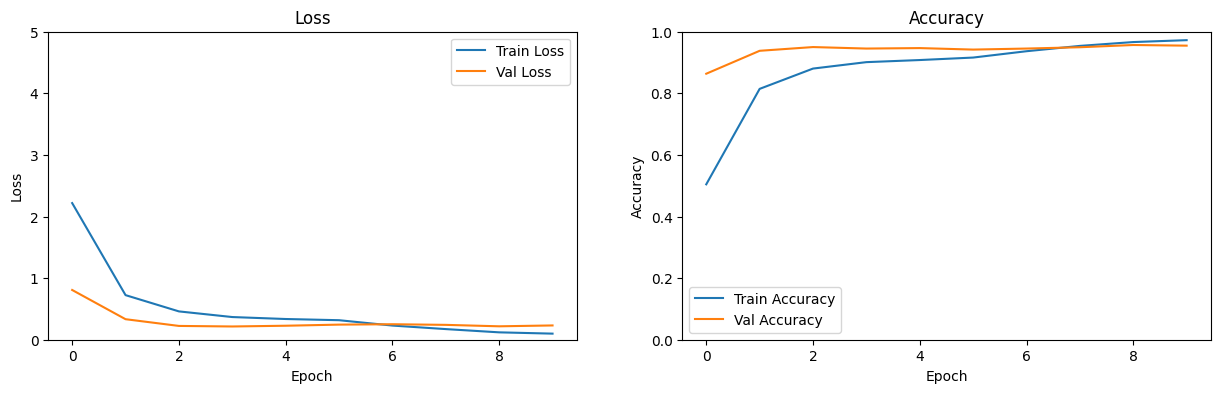

In [37]:
for i in range(0, k_folds):
    print(f"####### MODEL FOLD {i} #######")
    train_acc = histories[f'model_f-{i}_train_accuracy']
    val_acc = histories[f'model_f-{i}_val_accuracy']
    train_loss = histories[f'model_f-{i}_train_loss']
    val_loss = histories[f'model_f-{i}_val_loss']

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 4)

    # Plotting loss
    ax[0].set_ylim([0, 5])
    ax[0].plot(train_loss, label='Train Loss')
    ax[0].plot(val_loss, label='Val Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_title('Loss')
    ax[0].legend()

    # Plotting accuracy
    ax[1].set_ylim([0, 1])
    ax[1].plot(train_acc, label='Train Accuracy')
    ax[1].plot(val_acc, label='Val Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.show()

The model converge very fast (~3 epochs) and have an accuracy of ~0.95 accross all the fold. A better learning rate strategy and a better data augmentation could help the model converging slower but with a better generalisation ? 

# Submission

Loading the test dataset and dataloader

In [17]:
# free memory as `dataset` is no longer needed
del dataset
gc.collect()

27

In [17]:
test_data = dataset = FlowerDataset(DATASET_PATH, 'test', transform=val_transform)
# the batch size can drastically be raise up since the model will not be trained, more GPU memory will be available.
test_dataloader = DataLoader(test_data, batch_size=256, num_workers=N_WORKERS)

Loading the previously trained weights

In [23]:
for i in range(0, k_folds):
    path = f'./models/model_f-{i}.pth'
    k_models[i].load_state_dict(torch.load(path))

In [50]:
ids = []
preds = []

# Make predictions with each model and average them
with torch.no_grad():
    for sample_id, _, inputs in test_dataloader:
        inputs = inputs.to(DEVICE)
        ids.extend(sample_id)
        mean_logps = []

        for model in k_models:
            model.to(DEVICE)
            model.eval()
            outputs = model(inputs)
            mean_logps.append(outputs)
            # free GPU memory
            model.cpu()
            del model
            gc.collect()
        
        mean_logp = torch.mean(torch.stack(mean_logps), dim=0)
        preds.extend(torch.argmax(mean_logp, dim=1).tolist())

  0%|          | 0/29 [00:00<?, ?it/s]

In [51]:
submission = pd.DataFrame({'id': ids, 'label': preds})
submission.head()

,id,label
0,8d808a07b,53
1,c2c5a8cc9,7
2,550290aaa,13
3,45a842008,64
4,acf17fceb,103


In [52]:
submission.to_csv('submission.csv', index=False)

# Final accuracy

The final accuracy is 0.967 :

![Final Accuracy](./final_acc.png)